# DQN

FINALLY! Deep Q-Networks! Using neural networks to map observations to Q-Values! Let's get it! Today, we're gonna use DQN to solve the CartPole environment

Go see the python version of this document to view the full code. This was a drafting area.

In [2]:
import argparse
import os
import sys
import random
import time
from dataclasses import dataclass
from distutils.util import strtobool
from typing import Any, List, Optional, Union, Tuple, Iterable
import gym
import numpy as np
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
from gym.spaces import Discrete, Box
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from numpy.random import Generator
import gym.envs.registration
import pandas as pd
from w6d2.utils import make_env
from w6d4 import utils

MAIN = __name__ == "__main__"
os.environ["SDL_VIDEODRIVER"] = "dummy"

/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## Architecture for the Q-Network

For CartPole, we're just going to use a standard MLP constructed of alternative Linear and ReLU layers. Nice and Simple

In [62]:
class QNetwork(nn.Module):
    def __init__(self, dim_observation: int, num_actions: int, hidden_sizes: list[int] = [120, 84]):
        super().__init__()
        network = []
        network.append(nn.Linear(dim_observation, hidden_sizes[0]))
        network.append(nn.ReLU())
        for i in range(len(hidden_sizes) - 1):
            network.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            network.append(nn.ReLU())
        network.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], num_actions))
        # no relu at the end in order for the network to provided negative Q-values
        self.network = nn.Sequential(*network)

    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.network(x)

if MAIN:
    net = QNetwork(dim_observation=4, num_actions=2)
    n_params = sum((p.nelement() for p in net.parameters()))
    print(net)
    print(f"Total number of parameters: {n_params}")
    print("You should manually verify network is Linear-ReLU-Linear-ReLU-Linear")
    assert n_params == 10934

QNetwork(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=2, bias=True)
  )
)
Total number of parameters: 10934
You should manually verify network is Linear-ReLU-Linear-ReLU-Linear


## Experience Replay Buffer

In [63]:
@dataclass
class ReplayBufferSamples:
    '''
    Samples from the replay buffer, converted to PyTorch for use in neural network training.
    obs: shape (sample_size, *observation_shape), dtype t.float
    actions: shape (sample_size, ) dtype t.int
    rewards: shape (sample_size, ), dtype t.float
    dones: shape (sample_size, ), dtype t.bool
    next_observations: shape (sample_size, *observation_shape), dtype t.float
    '''

    observations: t.Tensor
    actions: t.Tensor
    rewards: t.Tensor
    dones: t.Tensor
    next_observations: t.Tensor


class ReplayBuffer:
    # rng: Generator
    # observations: t.Tensor
    # actions: t.Tensor
    # rewards: t.Tensor
    # dones: t.Tensor
    # next_observations: t.Tensor

    def __init__(self, buffer_size: int, num_actions: int, observation_shape: tuple, num_environments: int, seed: int):
        assert num_environments == 1, "This buffer only supports SyncVectorEnv with 1 environment inside."
        self.full = False
        self.buffer_size = buffer_size
        self.num_actions = num_actions
        self.observation_shape = observation_shape
        self.rng = np.random.default_rng(seed)
        self.index = 0

        self.observations = np.zeros((buffer_size,) + observation_shape, dtype=np.float64)
        self.actions = np.zeros(buffer_size, dtype=np.int64)
        self.rewards = np.zeros(buffer_size, dtype=np.float64)
        self.dones = np.zeros(buffer_size, dtype=np.float64)
        self.next_observations = np.zeros((buffer_size,) + observation_shape, dtype=np.float64)

    def add(
        self, obs: np.ndarray, actions: np.ndarray, rewards: np.ndarray, dones: np.ndarray, next_obs: np.ndarray
    ) -> None:
        '''
        obs: shape (num_environments, *observation_shape) 
            Observation before the action
        actions: shape (num_environments, ) 
            Action chosen by the agent
        rewards: shape (num_environments, ) 
            Reward after the action
        dones: shape (num_environments, ) 
            If True, the episode ended and was reset automatically
        next_obs: shape (num_environments, *observation_shape) 
            Observation after the action
            If done is True, this should be the terminal observation, NOT the first observation of the next episode.
        '''

        self.observations[self.index] = obs
        self.rewards[self.index] = rewards
        self.dones[self.index] = dones
        self.next_observations[self.index] = next_obs

        self.index += 1

        if self.index == self.buffer_size:
            self.full = True
            self.index = 0

    def sample(self, sample_size: int, device: t.device) -> ReplayBufferSamples:
        '''Uniformly sample sample_size entries from the buffer and convert them to PyTorch tensors on device.
        Sampling is with replacement, and sample_size may be larger than the buffer size.
        '''
        if self.full:
            random_indices = self.rng.integers(0, self.buffer_size, size = sample_size)
        else:
            random_indices = self.rng.integers(0, self.index, size = sample_size)

        return ReplayBufferSamples(
            observations = t.as_tensor(self.observations[random_indices]),
            actions = t.as_tensor(self.actions[random_indices]),
            rewards = t.as_tensor(self.rewards[random_indices]),
            dones = t.as_tensor(self.dones[random_indices], dtype=t.bool),
            next_observations= t.as_tensor(self.next_observations[random_indices])
        )
if MAIN:
    utils.test_replay_buffer_single(ReplayBuffer)
    utils.test_replay_buffer_deterministic(ReplayBuffer)
    utils.test_replay_buffer_wraparound(ReplayBuffer)

/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


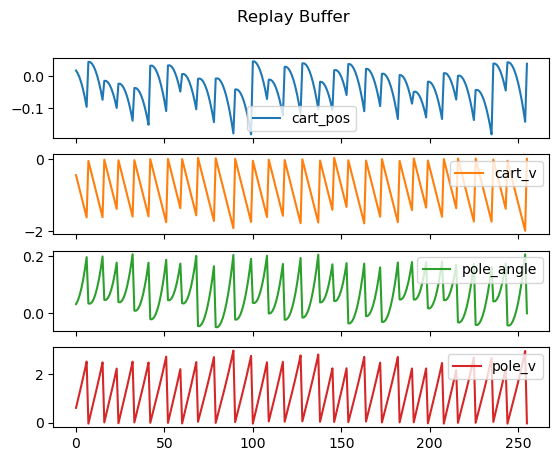

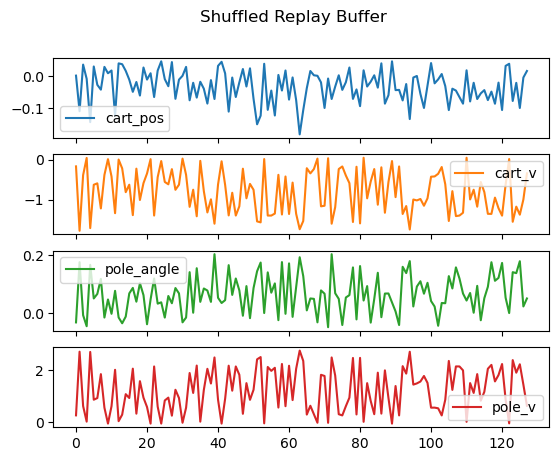

In [64]:
if MAIN:
    rb = ReplayBuffer(buffer_size=256, num_actions=2, observation_shape=(4,), num_environments=1, seed=0)
    envs = gym.vector.SyncVectorEnv([utils.make_env("CartPole-v1", 0, 0, False, "test")])
    obs = envs.reset()
    for i in range(512):
        actions = np.array([0])
        (next_obs, rewards, dones, infos) = envs.step(actions)
        real_next_obs = next_obs.copy()
        #for (i, done) in enumerate(dones):
            #if done:
                #real_next_obs[i] = infos[i]["terminal_observation"] TODO - just deleted it. there is no "terminal_observation" here...
        rb.add(obs, actions, rewards, dones, next_obs) # TODO: is this supposed to be real_next_obs[i] here?
        obs = next_obs
    sample = rb.sample(128, t.device("cpu"))
    columns = ["cart_pos", "cart_v", "pole_angle", "pole_v"]
    df = pd.DataFrame(rb.observations, columns=columns)
    df.plot(subplots=True, title="Replay Buffer")
    df2 = pd.DataFrame(sample.observations, columns=columns)
    df2.plot(subplots=True, title="Shuffled Replay Buffer")

We will use a basic exploration technique.

In [65]:
def linear_schedule(
    current_step: int, start_e: float, end_e: float, exploration_fraction: float, total_timesteps: int
) -> float:
    '''Return the appropriate epsilon for the current step.

    Epsilon should be start_e at step 0 and decrease linearly to end_e at step (exploration_fraction * total_timesteps).

    It should stay at end_e for the rest of the episode.
    '''
    num_steps = exploration_fraction * total_timesteps
    return max(start_e - (start_e - end_e) * current_step / num_steps, end_e)
    

if MAIN:
    epsilons = [
        linear_schedule(step, start_e=1.0, end_e=0.05, exploration_fraction=0.5, total_timesteps=500)
        for step in range(500)
    ]
    utils.test_linear_schedule(linear_schedule)

In [66]:
def epsilon_greedy_policy(
    envs: gym.vector.SyncVectorEnv, q_network: QNetwork, rng: Generator, obs: t.Tensor, epsilon: float
) -> np.ndarray:
    '''With probability epsilon, take a random action. Otherwise, take a greedy action according to the q_network.
    Inputs:
        envs : gym.vector.SyncVectorEnv, the family of environments to run against
        q_network : QNetwork, the network used to approximate the Q-value function
        obs : The current observation
        epsilon : exploration percentage
    Outputs:
        actions: (n_environments, ) the sampled action for each environment.
    '''
    if rng.uniform() < epsilon:
        return rng.integers(envs.single_action_space.n, size=envs.num_envs) #we assume all the envs are the same
    else:
        q_values = q_network(obs)
        return t.argmax(q_values, dim=-1).numpy()

if MAIN:
    utils.test_epsilon_greedy_policy(epsilon_greedy_policy)

/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


## Probe Environment

In [67]:
ObsType = np.ndarray
ActType = int

class Probe1(gym.Env):
    '''One action, observation of [0.0], one timestep long, +1 reward.

    We expect the agent to rapidly learn that the value of the constant [0.0] observation is +1.0. Note we're using a continuous observation space for consistency with CartPole.
    '''

    action_space: Discrete
    observation_space: Box

    def __init__(self):
        super().__init__()
        self.observation_space = Box(np.array([0]), np.array([0]))
        self.action_space = Discrete(1)
        self.seed()
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        return (np.array([0]), 1.0, True, {})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        if return_info:
            return (np.array([0.0]), {})
        return np.array([0.0])

gym.envs.registration.register(id="Probe1-v0", entry_point=Probe1)
if MAIN:
    env = gym.make("Probe1-v0")
    assert env.observation_space.shape == (1,)
    assert env.action_space.shape == ()

/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment Probe1-v0
  logger.warn(f"Overriding environment {id}")
/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Some setup for Weights and Biases:

In [68]:
@dataclass
class DQNArgs:
    exp_name: str = os.path.basename(globals().get("__file__", "DQN_implementation").rstrip(".py"))
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True
    track: bool = False
    wandb_project_name: str = "CartPoleDQN"
    wandb_entity: Optional[str] = None
    capture_video: bool = True
    env_id: str = "CartPole-v1"
    total_timesteps: int = 500000
    learning_rate: float = 0.00025
    buffer_size: int = 10000
    gamma: float = 0.99
    target_network_frequency: int = 500
    batch_size: int = 128
    start_e: float = 1.0
    end_e: float = 0.05
    exploration_fraction: float = 0.5
    learning_starts: int = 10000
    train_frequency: int = 10

arg_help_strings = dict(
    exp_name = "the name of this experiment",
    seed = "seed of the experiment",
    torch_deterministic = "if toggled, `torch.backends.cudnn.deterministic=False`",
    cuda = "if toggled, cuda will be enabled by default",
    track = "if toggled, this experiment will be tracked with Weights and Biases",
    wandb_project_name = "the wandb's project name",
    wandb_entity = "the entity (team) of wandb's project",
    capture_video = "whether to capture videos of the agent performances (check out `videos` folder)",
    env_id = "the id of the environment",
    total_timesteps = "total timesteps of the experiments",
    learning_rate = "the learning rate of the optimizer",
    buffer_size = "the replay memory buffer size",
    gamma = "the discount factor gamma",
    target_network_frequency = "the timesteps it takes to update the target network",
    batch_size = "the batch size of samples from the replay memory",
    start_e = "the starting epsilon for exploration",
    end_e = "the ending epsilon for exploration",
    exploration_fraction = "the fraction of `total-timesteps` it takes from start-e to go end-e",
    learning_starts = "timestep to start learning",
    train_frequency = "the frequency of training",
)
toggles = ["torch_deterministic", "cuda", "track", "capture_video"]

def parse_args(arg_help_strings=arg_help_strings, toggles=toggles) -> DQNArgs:
    parser = argparse.ArgumentParser()
    for (name, field) in DQNArgs.__dataclass_fields__.items():
        flag = "--" + name.replace("_", "-")
        type_function = field.type if field.type != bool else lambda x: bool(strtobool(x))
        toggle_kwargs = {"nargs": "?", "const": True} if name in toggles else {}
        parser.add_argument(
            flag, type=type_function, default=field.default, help=arg_help_strings[name], **toggle_kwargs
        )
    return DQNArgs(**vars(parser.parse_args()))

def setup(args: DQNArgs) -> Tuple[str, SummaryWriter, np.random.Generator, t.device, gym.vector.SyncVectorEnv]:
    '''Helper function to set up useful variables for the DQN implementation'''
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % "\n".join([f"|{key}|{value}|" for (key, value) in vars(args).items()]),
    )
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic
    rng = np.random.default_rng(args.seed)
    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    envs = gym.vector.SyncVectorEnv([utils.make_env(args.env_id, args.seed, 0, args.capture_video, run_name)])
    assert isinstance(envs.single_action_space, Discrete), "only discrete action space is supported"
    return (run_name, writer, rng, device, envs)

def log(
    writer: SummaryWriter,
    start_time: float,
    step: int,
    predicted_q_vals: t.Tensor,
    loss: Union[float, t.Tensor],
    infos: Iterable[dict],
    epsilon: float,
):
    '''Helper function to write relevant info to TensorBoard logs, and print some things to stdout'''
    if step % 100 == 0:
        writer.add_scalar("losses/td_loss", loss, step)
        writer.add_scalar("losses/q_values", predicted_q_vals.mean().item(), step)
        writer.add_scalar("charts/SPS", int(step / (time.time() - start_time)), step)
        if step % 10000 == 0:
            print("SPS:", int(step / (time.time() - start_time)))
    for info in infos:
        if "episode" in info.keys():
            print(f"global_step={step}, episodic_return={info['episode']['r']}")
            writer.add_scalar("charts/episodic_return", info["episode"]["r"], step)
            writer.add_scalar("charts/episodic_length", info["episode"]["l"], step)
            writer.add_scalar("charts/epsilon", epsilon, step)
            break

Deep Q Learning!

In [89]:
def train_dqn(args: DQNArgs):
    (run_name, writer, rng, device, envs) = setup(args)
    
    
    # Create a Q-network, Adam optimizer, and replay buffer here.
    obs_shape = envs.single_observation_space.shape
    num_observations = np.array(obs_shape, dtype=int).prod()
    q_network = QNetwork(num_observations, envs.single_action_space.n)
    adam = optim.Adam(q_network.parameters(), args.learning_rate)

    targetNet = QNetwork(num_observations, envs.single_action_space.n)
    targetNet.load_state_dict(q_network.state_dict())

    rb = ReplayBuffer(args.batch_size, envs.single_action_space.n, obs_shape, len(envs.envs), args.seed)


    start_time = time.time()
    obs = envs.reset()
    for step in range(args.total_timesteps):
        # Sample actions according to the epsilon greedy policy using the linear schedule for epsilon, and then step the environment
        epsilon = linear_schedule(step,args.start_e, args.end_e,args.exploration_fraction, args.total_timesteps)
        actions = epsilon_greedy_policy(envs,q_network,rng,t.from_numpy(obs),epsilon)
        next_obs, rewards, dones, info = envs.step(actions)

        "Boilerplate to handle the terminal observation case"
        real_next_obs = next_obs.copy()
        #for (i, done) in enumerate(dones):
            #if done:
                #real_next_obs[i] = infos[i]["terminal_observation"]
        rb.add(obs, actions, rewards, dones, next_obs)
        obs = next_obs
        if step > args.learning_starts and step % args.train_frequency == 0:
            "YOUR CODE: Sample from the replay buffer, compute the TD target, compute TD loss, and perform an optimizer step."
            samples = rb.sample(args.batch_size, device=device)
            with t.no_grad():
                target_max = targetNet(samples.next_observations.float()).max(dim=1).values
                td_target = (samples.rewards + args.gamma * target_max * (1 - samples.dones.float())).float()


            predicted_q_vals = q_network(samples.observations.float()).gather(1, rearrange(sample.actions, "a -> a 1")).float()
            loss = F.mse_loss(td_target, predicted_q_vals).float()            
            loss.backward()
            adam.step()
            if step % args.target_network_frequency == 0:
                targetNet.load_state_dict(q_network.state_dict())

            log(writer, start_time, step, predicted_q_vals, loss, infos, epsilon)

    "If running one of the Probe environments, will test if the learned q-values are\n    sensible after training. Useful for debugging."
    probe_batches = [
        t.tensor([[0.0]]), t.tensor([[-1.0], [+1.0]]), t.tensor([[0.0], [1.0]]), t.tensor([[0.0]]), t.tensor([[0.0], [1.0]])
    ]
    if re.match(r"Probe(\d)-v0", args.env_id):
        probe_no = int(re.match(r"Probe(\d)-v0", args.env_id).group(1))
        batch = probe_batches[probe_no]
        value = q_network(batch)
        print("Value: ", value)
        expected = t.tensor([[1.0]]).to(device)
        t.testing.assert_close(value, expected, 0.0001)

    envs.close()
    writer.close()

if MAIN:
    if "ipykernel_launcher" in os.path.basename(sys.argv[0]):
        filename = globals().get("__file__", "<filename of this script>")
        print(f"Try running this file from the command line instead: python {os.path.basename(filename)} --help")
        args = DQNArgs()
    else:
        args = parse_args()
    train_dqn(args)

Try running this file from the command line instead: python <filename of this script> --help


/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(
/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `

SPS: 4144


/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/var/folders/38/0hzg6tlx5p3bm5hlwqmzl3mw0000gn/T/ipykernel_15406/4055477676.py:41: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(td_target, predicted_q_vals).float()


SPS: 3547
SPS: 3416


/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:115: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/var/folders/38/0hzg6tlx5p3bm5hlwqmzl3mw0000gn/T/ipykernel_15406/4055477676.py:41: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(td_target, predicted_q_vals).float()


SPS: 3285


KeyboardInterrupt: 